# 線形回帰モデルの比較

## 必要なライブラリをインポート

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## CSVファイルの読み込み

In [ ]:
dataset_df = pd.read_csv("dataset.csv")
dataset_df.head()

,distance,width,speed,crowd_level,time
0,120.400000,1.0,1.4,1,86
1,103.549615,1.0,1.7,1,61
2,95.000000,1.0,1.0,1,95
3,85.000000,1.0,1.0,1,85
4,62.000000,1.0,1.0,1,62


## データセットの整形

In [ ]:
# "crowd_level"を文字列型に変換
dataset_df["crowd_level"] = dataset_df["crowd_level"].astype(str)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   distance     10000 non-null  float64
 1   width        10000 non-null  float64
 2   speed        10000 non-null  float64
 3   crowd_level  10000 non-null  object 
 4   time         10000 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 390.8+ KB


In [ ]:
# One-Hot Encoding
dataset_df = pd.get_dummies(dataset_df, columns=["crowd_level"], drop_first=True)
dataset_df.head()

,distance,width,speed,time,crowd_level_2,crowd_level_3,crowd_level_4,crowd_level_5
0,120.400000,1.0,1.4,86,0,0,0,0
1,103.549615,1.0,1.7,61,0,0,0,0
2,95.000000,1.0,1.0,95,0,0,0,0
3,85.000000,1.0,1.0,85,0,0,0,0
4,62.000000,1.0,1.0,62,0,0,0,0


## モデル1
- 説明変数：width, speed, crowd_level_2, crowd_level_3, crowd_level_4, crowd_level_5
- 目的変数：$ \frac{\text{time}}{\text{distance}} $

In [ ]:
# 説明変数と目的変数に分割
X = dataset_df.drop(["distance", "time"], axis=1).values
y = (dataset_df["time"] / dataset_df["distance"]).values

print(X[:5])
print(y[:5])

[[1.  1.4 0.  0.  0.  0. ]
 [1.  1.7 0.  0.  0.  0. ]
 [1.  1.  0.  0.  0.  0. ]
 [1.  1.  0.  0.  0.  0. ]
 [1.  1.  0.  0.  0.  0. ]]
[0.71428571 0.58908959 1.         1.         1.        ]


In [ ]:
# NumPy配列をPyTorchテンソルに変換
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# サイズを(N, 1)に変更
y = y.view(-1, 1)
print(y.shape)

torch.Size([10000, 1])


In [ ]:
class LinearRegressionModel_1(nn.Module):
    """ 線形回帰モデル1 """

    def __init__(self, input_dim: int, output_dim: int) -> None:
        """
        コンストラクタ

        Parameters
        ----------
        input_dim : int
            入力次元数
        output_dim : int
            出力次元数
        """
        super().__init__()
        self.l1 = nn.Linear(input_dim, output_dim)

        nn.init.constant_(self.l1.weight, 1.0)
        nn.init.constant_(self.l1.bias, 1.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播

        Returns
        -------
        torch.Tensor
            1層目の出力
        """
        return self.l1(x)

In [ ]:
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 標準化処理
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# PyTorchテンソルに変換
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)

# モデルのインスタンス化
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model_1 = LinearRegressionModel_1(input_dim, output_dim)

# 損失関数の設定
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()

# 最適化アルゴリズムの設定
lr = 0.01
optimizer = optim.SGD(model_1.parameters(), lr=lr)
# optimizer = optim.Adam(model_1.parameters(), lr=lr)

# 学習記録用
history = np.zeros((0, 2))

# モデルの訓練
epochs = 1100
for epoch in range(epochs):

    # 勾配値の初期化
    optimizer.zero_grad()

    # 予測計算（順伝播）
    outputs = model_1(X_train_std)

    # 損失計算（MSE）
    mse_loss = criterion_mse(outputs, y_train)

    # 損失計算（MAE）
    mae_loss = criterion_mae(outputs, y_train)

    # 勾配計算（逆伝播）
    mse_loss.backward()

    # パラメータの更新
    optimizer.step()

    # エポック10回ごとに途中経過を記録
    if (epoch % 10 == 0):
        history = np.vstack((history, np.array([epoch, mse_loss.item()])))
        print(f"Epoch {epoch}: MSE_loss = {mse_loss.item()}, MAE_loss = {mae_loss.item()}")
    elif (epoch + 1 == epochs):
        history = np.vstack((history, np.array([epoch, mse_loss.item()])))
        print(f"Epoch {epoch}: MSE_loss = {mse_loss.item()}, MAE_loss = {mae_loss.item()}")

Epoch 0: MSE_loss = 3.410243272781372, MAE_loss = 1.5026700496673584
Epoch 10: MSE_loss = 2.487292528152466, MAE_loss = 1.2798269987106323
Epoch 20: MSE_loss = 1.853684902191162, MAE_loss = 1.1000523567199707
Epoch 30: MSE_loss = 1.4141610860824585, MAE_loss = 0.9576854109764099
Epoch 40: MSE_loss = 1.1053009033203125, MAE_loss = 0.8438091278076172
Epoch 50: MSE_loss = 0.8848277926445007, MAE_loss = 0.7508698105812073
Epoch 60: MSE_loss = 0.724514901638031, MAE_loss = 0.6748320460319519
Epoch 70: MSE_loss = 0.6054765582084656, MAE_loss = 0.6131986379623413
Epoch 80: MSE_loss = 0.5150426030158997, MAE_loss = 0.5625559687614441
Epoch 90: MSE_loss = 0.44468334317207336, MAE_loss = 0.5212488174438477
Epoch 100: MSE_loss = 0.38863009214401245, MAE_loss = 0.48638519644737244
Epoch 110: MSE_loss = 0.34295782446861267, MAE_loss = 0.4571268856525421
Epoch 120: MSE_loss = 0.30497580766677856, MAE_loss = 0.4317440390586853
Epoch 130: MSE_loss = 0.2728208303451538, MAE_loss = 0.40933290123939514
E

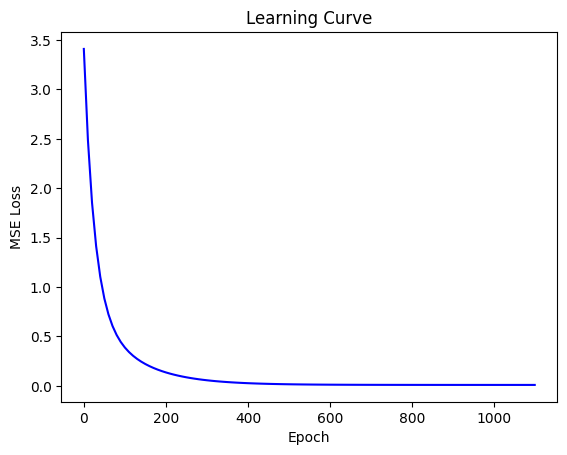

In [ ]:
# 学習曲線
plt.plot(history[:, 0], history[:, 1], "b")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.show()

In [ ]:
# 全テストデータでモデルを評価
with torch.no_grad():
    outputs = model_1(X_test_std)
    mse_loss = criterion_mse(outputs, y_test)
    mae_loss = criterion_mae(outputs, y_test)
    print(f"All test data: MSE_loss = {mse_loss.item()}, MAE_loss = {mae_loss.item()}")

All test data: MSE_loss = 0.010000219568610191, MAE_loss = 0.07520106434822083


In [ ]:
# テストデータを混雑度別に分ける
X = dataset_df.drop(["distance", "time"], axis=1)
y = dataset_df["time"] / dataset_df["distance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

test_index_1 = X_test[(X_test["crowd_level_2"] == 0) & (X_test["crowd_level_3"] == 0) & (X_test["crowd_level_4"] == 0) & (X_test["crowd_level_5"] == 0)].index
test_index_2 = X_test[X_test["crowd_level_2"] == 1].index
test_index_3 = X_test[X_test["crowd_level_3"] == 1].index
test_index_4 = X_test[X_test["crowd_level_4"] == 1].index
test_index_5 = X_test[X_test["crowd_level_5"] == 1].index

X_test_1 = X_test.loc[test_index_1].values
y_test_1 = y_test.loc[test_index_1].values
X_test_2 = X_test.loc[test_index_2].values
y_test_2 = y_test.loc[test_index_2].values
X_test_3 = X_test.loc[test_index_3].values
y_test_3 = y_test.loc[test_index_3].values
X_test_4 = X_test.loc[test_index_4].values
y_test_4 = y_test.loc[test_index_4].values
X_test_5 = X_test.loc[test_index_5].values
y_test_5 = y_test.loc[test_index_5].values

X_test_1 = torch.tensor(X_test_1, dtype=torch.float32)
y_test_1 = torch.tensor(y_test_1, dtype=torch.float32)
X_test_2 = torch.tensor(X_test_2, dtype=torch.float32)
y_test_2 = torch.tensor(y_test_2, dtype=torch.float32)
X_test_3 = torch.tensor(X_test_3, dtype=torch.float32)
y_test_3 = torch.tensor(y_test_3, dtype=torch.float32)
X_test_4 = torch.tensor(X_test_4, dtype=torch.float32)
y_test_4 = torch.tensor(y_test_4, dtype=torch.float32)
X_test_5 = torch.tensor(X_test_5, dtype=torch.float32)
y_test_5 = torch.tensor(y_test_5, dtype=torch.float32)

y_test_1 = y_test_1.view(-1, 1)
y_test_2 = y_test_2.view(-1, 1)
y_test_3 = y_test_3.view(-1, 1)
y_test_4 = y_test_4.view(-1, 1)
y_test_5 = y_test_5.view(-1, 1)

X_test_std_1 = sc.transform(X_test_1)
X_test_std_2 = sc.transform(X_test_2)
X_test_std_3 = sc.transform(X_test_3)
X_test_std_4 = sc.transform(X_test_4)
X_test_std_5 = sc.transform(X_test_5)

X_test_std_1 = torch.tensor(X_test_std_1, dtype=torch.float32)
X_test_std_2 = torch.tensor(X_test_std_2, dtype=torch.float32)
X_test_std_3 = torch.tensor(X_test_std_3, dtype=torch.float32)
X_test_std_4 = torch.tensor(X_test_std_4, dtype=torch.float32)
X_test_std_5 = torch.tensor(X_test_std_5, dtype=torch.float32)

X_test_std_n = [X_test_std_1, X_test_std_2, X_test_std_3, X_test_std_4, X_test_std_5]
y_test_n = [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5]

In [ ]:
# 混雑度別のテストデータでモデル1を評価
for i in range(len(X_test_std_n)):
    with torch.no_grad():
        outputs = model_1(X_test_std_n[i])
        mse_loss = criterion_mse(outputs, y_test_n[i])
        mae_loss = criterion_mae(outputs, y_test_n[i])
        print(f"Crowd level {i + 1}: MSE_loss = {mse_loss.item()}, MAE_loss = {mae_loss.item()}")

Crowd level 1: MSE_loss = 0.004543659742921591, MAE_loss = 0.049247726798057556
Crowd level 2: MSE_loss = 0.004598658066242933, MAE_loss = 0.054462283849716187
Crowd level 3: MSE_loss = 0.00836536381393671, MAE_loss = 0.07208546996116638
Crowd level 4: MSE_loss = 0.01277884654700756, MAE_loss = 0.08797544986009598
Crowd level 5: MSE_loss = 0.02015756070613861, MAE_loss = 0.11415471881628036


## モデル2
- 説明変数：width, speed, crowd_level_2, crowd_level_3, crowd_level_4, crowd_level_5
- 目的変数：
$ \frac{1}{\text{distance}} \left( \text{time} - \frac{\text{distance}}{\text{speed}} \right) = \frac{\text{time}}{\text{distance}} - \frac{1}{\text{speed}} $

In [ ]:
# 説明変数と目的変数に分割
X = dataset_df.drop(["distance", "time"], axis=1).values
y = ((dataset_df["time"] / dataset_df["distance"]) - (1 / dataset_df["speed"])).values

print(X[:5])
print(y[:5])

[[1.  1.4 0.  0.  0.  0. ]
 [1.  1.7 0.  0.  0.  0. ]
 [1.  1.  0.  0.  0.  0. ]
 [1.  1.  0.  0.  0.  0. ]
 [1.  1.  0.  0.  0.  0. ]]
[-1.22124533e-15  8.54291458e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


In [ ]:
# NumPy配列をPyTorchテンソルに変換
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# サイズを(N, 1)に変更
y = y.view(-1, 1)
print(y.shape)

torch.Size([10000, 1])


In [ ]:
class LinearRegressionModel_2(nn.Module):
    """ 線形回帰モデル2 """

    def __init__(self, input_dim: int, output_dim: int) -> None:
        """
        コンストラクタ

        Parameters
        ----------
        input_dim : int
            入力次元数
        output_dim : int
            出力次元数
        """
        super().__init__()
        self.l1 = nn.Linear(input_dim, output_dim)

        nn.init.constant_(self.l1.weight, 1.0)
        nn.init.constant_(self.l1.bias, 1.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播

        Returns
        -------
        torch.Tensor
            1層目の出力
        """
        return self.l1(x)

In [ ]:
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 標準化処理
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# PyTorchテンソルに変換
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)

# モデルのインスタンス化
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model_2 = LinearRegressionModel_2(input_dim, output_dim)

# 損失関数の設定
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()

# 最適化アルゴリズムの設定
lr = 0.01
optimizer = optim.SGD(model_2.parameters(), lr=lr)
# optimizer = optim.Adam(model_2.parameters(), lr=lr)

# 学習記録用
history = np.zeros((0, 2))

# モデルの訓練
epochs = 3000
for epoch in range(epochs):

    # 勾配値の初期化
    optimizer.zero_grad()

    # 予測計算（順伝播）
    outputs = model_2(X_train_std)

    # 損失計算（MSE）
    mse_loss = criterion_mse(outputs, y_train)

    # 損失計算（MAE）
    mae_loss = criterion_mae(outputs, y_train)

    # 勾配計算（逆伝播）
    mse_loss.backward()

    # パラメータの更新
    optimizer.step()

    # エポック10回ごとに途中経過を記録
    if (epoch % 10 == 0):
        history = np.vstack((history, np.array([epoch, mse_loss.item()])))
        print(f"Epoch {epoch}: MSE_loss = {mse_loss.item()}, MAE_loss = {mae_loss.item()}")
    elif (epoch + 1 == epochs):
        history = np.vstack((history, np.array([epoch, mse_loss.item()])))
        print(f"Epoch {epoch}: MSE_loss = {mse_loss.item()}, MAE_loss = {mae_loss.item()}")

Epoch 0: MSE_loss = 3.8307549953460693, MAE_loss = 1.619201421737671
Epoch 10: MSE_loss = 2.7699813842773438, MAE_loss = 1.3834949731826782
Epoch 20: MSE_loss = 2.0437726974487305, MAE_loss = 1.196063756942749
Epoch 30: MSE_loss = 1.5420200824737549, MAE_loss = 1.046999454498291
Epoch 40: MSE_loss = 1.1913257837295532, MAE_loss = 0.9274941682815552
Epoch 50: MSE_loss = 0.9427126049995422, MAE_loss = 0.8314748406410217
Epoch 60: MSE_loss = 0.763453483581543, MAE_loss = 0.7524040937423706
Epoch 70: MSE_loss = 0.6316421627998352, MAE_loss = 0.6861812472343445
Epoch 80: MSE_loss = 0.5325812697410583, MAE_loss = 0.630595326423645
Epoch 90: MSE_loss = 0.45638054609298706, MAE_loss = 0.5834068059921265
Epoch 100: MSE_loss = 0.3963583707809448, MAE_loss = 0.5423284769058228
Epoch 110: MSE_loss = 0.3479771316051483, MAE_loss = 0.5058245658874512
Epoch 120: MSE_loss = 0.30813509225845337, MAE_loss = 0.47316646575927734
Epoch 130: MSE_loss = 0.2746931314468384, MAE_loss = 0.4438253939151764
Epoch

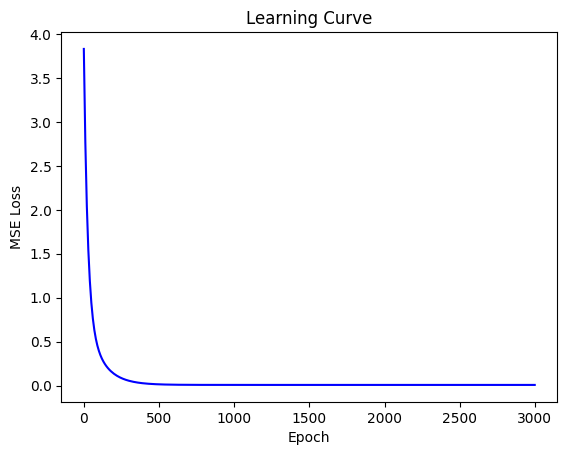

In [ ]:
# 学習曲線
plt.plot(history[:, 0], history[:, 1], "b")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.show()

In [ ]:
# 全テストデータでモデルを評価
with torch.no_grad():
    outputs = model_2(X_test_std)
    mse_loss = criterion_mse(outputs, y_test)
    mae_loss = criterion_mae(outputs, y_test)
    print(f"All test data: MSE_loss = {mse_loss.item()}, MAE_loss = {mae_loss.item()}")

All test data: MSE_loss = 0.007915589958429337, MAE_loss = 0.06271534413099289


In [ ]:
# テストデータを混雑度別に分ける
X = dataset_df.drop(["distance", "time"], axis=1)
y = (dataset_df["time"] / dataset_df["distance"]) - (1 / dataset_df["speed"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

test_index_1 = X_test[(X_test["crowd_level_2"] == 0) & (X_test["crowd_level_3"] == 0) & (X_test["crowd_level_4"] == 0) & (X_test["crowd_level_5"] == 0)].index
test_index_2 = X_test[X_test["crowd_level_2"] == 1].index
test_index_3 = X_test[X_test["crowd_level_3"] == 1].index
test_index_4 = X_test[X_test["crowd_level_4"] == 1].index
test_index_5 = X_test[X_test["crowd_level_5"] == 1].index

X_test_1 = X_test.loc[test_index_1].values
y_test_1 = y_test.loc[test_index_1].values
X_test_2 = X_test.loc[test_index_2].values
y_test_2 = y_test.loc[test_index_2].values
X_test_3 = X_test.loc[test_index_3].values
y_test_3 = y_test.loc[test_index_3].values
X_test_4 = X_test.loc[test_index_4].values
y_test_4 = y_test.loc[test_index_4].values
X_test_5 = X_test.loc[test_index_5].values
y_test_5 = y_test.loc[test_index_5].values

X_test_1 = torch.tensor(X_test_1, dtype=torch.float32)
y_test_1 = torch.tensor(y_test_1, dtype=torch.float32)
X_test_2 = torch.tensor(X_test_2, dtype=torch.float32)
y_test_2 = torch.tensor(y_test_2, dtype=torch.float32)
X_test_3 = torch.tensor(X_test_3, dtype=torch.float32)
y_test_3 = torch.tensor(y_test_3, dtype=torch.float32)
X_test_4 = torch.tensor(X_test_4, dtype=torch.float32)
y_test_4 = torch.tensor(y_test_4, dtype=torch.float32)
X_test_5 = torch.tensor(X_test_5, dtype=torch.float32)
y_test_5 = torch.tensor(y_test_5, dtype=torch.float32)

y_test_1 = y_test_1.view(-1, 1)
y_test_2 = y_test_2.view(-1, 1)
y_test_3 = y_test_3.view(-1, 1)
y_test_4 = y_test_4.view(-1, 1)
y_test_5 = y_test_5.view(-1, 1)

X_test_std_1 = sc.transform(X_test_1)
X_test_std_2 = sc.transform(X_test_2)
X_test_std_3 = sc.transform(X_test_3)
X_test_std_4 = sc.transform(X_test_4)
X_test_std_5 = sc.transform(X_test_5)

X_test_std_1 = torch.tensor(X_test_std_1, dtype=torch.float32)
X_test_std_2 = torch.tensor(X_test_std_2, dtype=torch.float32)
X_test_std_3 = torch.tensor(X_test_std_3, dtype=torch.float32)
X_test_std_4 = torch.tensor(X_test_std_4, dtype=torch.float32)
X_test_std_5 = torch.tensor(X_test_std_5, dtype=torch.float32)

X_test_std_n = [X_test_std_1, X_test_std_2, X_test_std_3, X_test_std_4, X_test_std_5]
y_test_n = [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5]

In [ ]:
# 混雑度別のテストデータでモデルを評価
for i in range(len(X_test_std_n)):
    with torch.no_grad():
        outputs = model_2(X_test_std_n[i])
        mse_loss = criterion_mse(outputs, y_test_n[i])
        mae_loss = criterion_mae(outputs, y_test_n[i])
        print(f"Crowd level {i + 1}: MSE_loss = {mse_loss.item()}, MAE_loss = {mae_loss.item()}")

Crowd level 1: MSE_loss = 0.002067960798740387, MAE_loss = 0.03863091394305229
Crowd level 2: MSE_loss = 0.0024421238340437412, MAE_loss = 0.03775448352098465
Crowd level 3: MSE_loss = 0.0062262932769954205, MAE_loss = 0.051099542528390884
Crowd level 4: MSE_loss = 0.010585276409983635, MAE_loss = 0.07392901182174683
Crowd level 5: MSE_loss = 0.018725112080574036, MAE_loss = 0.11426977813243866


## 出力例

In [ ]:
# 例）distance=120, width=1.5, speed=1.2, crowd_level="3"
X_sample = np.array([[1.5, 1.2, 0, 1, 0, 0]])
# 標準化
X_sample_std = sc.transform(X_sample)
X_sample_std = torch.tensor(X_sample_std, dtype=torch.float32)

# モデル1
print(f"モデル1の出力 = {model_1(X_sample_std).item()}")
# モデル2
print(f"モデル2の出力 = {model_2(X_sample_std).item()}")

モデル1の出力 = 0.9362400770187378
モデル2の出力 = 0.05176441743969917


- モデル1を使用した場合、例題の条件下で120 m歩くのにかかる時間は、  
$ \hspace{20pt} 0.9362 \times 120 = 112.344 \, \text{s} $

- モデル2を使用した場合、例題の条件下で120 m歩くのにかかる時間は、  
$ \hspace{20pt} (1/1.2 + 0.0518) \times 120 = 106.216 \, \text{s} $

## 評価

1m歩いた時の平均時間誤差 (MAE) [s/m]

|  | 全体 | 混雑度1 | 混雑度2 |  混雑度3 |  混雑度4 |  混雑度5 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| モデル1 | 0.0752010643 | 0.0492477268 | 0.0544622838 | 0.0720854700 | 0.0879754499 | 0.1141547188 |
| モデル2 | 0.0627153441 | 0.0386309139 | 0.0377544835 | 0.0510995425 | 0.0739290118 | 0.1142697781 |